<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><img href="http://www.datascience-paris-saclay.fr" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" ></td>
    <td style="background-color:transparent;"><img href="https://research.pasteur.fr/en/team/group-roberto-toro" src="https://paris-saclay-cds.github.io/autism_challenge/images/institut_pasteur_logo.svg" ></td>
    <td style="background-color:black;"><img href="fer.unizg.hr" src="https://www.fer.unizg.hr/_pub/themes_static/fer2016/default/img/FER_logo.png"></td>
  </tr>
</table> 
</div>

<center><h1>Impact of sMRI preprocessing on autism classification using machine learning methods</h1></center>



<center><h3>Forked from data challenge on Autism Spectrum Disorder detection</h3></center>
<br/>
<center>_Roberto Toro (Institut Pasteur), Nicolas Traut (Institut Pasteur), Anita Beggiato (Institut Pasteur), Katja Heuer (Institut Pasteur),<br /> Gael Varoquaux (Inria, Parietal), Alex Gramfort (Inria, Parietal), Balazs Kegl (LAL),<br /> Guillaume Lemaitre (CDS), Alexandre Boucaud (CDS), and Joris van den Bossche (CDS)<br />Lana Barić(FER), Roko Krstičević(FER)</center>

## Table of Content

0. [Prerequisites](#Software-prerequisites)
1. [Introduction about the competition](#Introduction:-what-is-this-challenge-about)
3. [The data](#The-data)
4. [Workflow](#Workflow)
5. [Evaluation](#Evaluation)
6. [Submission](#Submitting-to-the-online-challenge:-ramp.studio)
7. [More information](#More-information)
8. [Questions](#Question)

**To download and run this notebook**: download the [full starting kit](https://github.com/ramp-kits/autism/archive/master.zip), with all the necessary files.

## Software prerequisites

This starting kit requires the following dependencies:

* `numpy`
* `scipy`
* `pandas`
* `scikit-learn`
* `matplolib`
* `seaborn`
* `nilearn`
* `jupyter`
* `ramp-workflow`

The following 2 cells will install if necessary the missing dependencies.

In [ ]:
# import sys
# !{sys.executable} -m pip install scikit-learn==0.21.3 seaborn==0.10.0 nilearn==0.7.1

Install `ramp-workflow` from the master branch on GitHub.

In [ ]:
# !{sys.executable} -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/0.2.1

In [ ]:
%load_ext autoreload
%autoreload 2

## Introduction: detecting autism

Autism spectrum disorder (ASD) is a developmental disorder affecting communication and behavior with different range in severity of symptoms. ASD has been reported to affect approximately 1 in 166 children.

Although there is a consensus on a relation between ASD and atypical brain networks and anatomy, those differences in brain anatomy and functional connectivity remain unclear. To address these issues, study on large cohort of subjects are necessary to ensure relevant finding. 

## The data
We start from downloading data from internet

In [1]:
from problem import get_train_data

data_train = get_train_data()

/home/hal9000/Projects/autism-smri/venv/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [2]:
data_train

,participants_site,participants_sex,participants_age,participants_asd,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,...,fmri_basc064,fmri_basc122,fmri_basc197,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_motions,fmri_msdl,fmri_power_2011,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,F,9.301370,0,977.0,427.0,1884.0,1449.0,463.0,2790.0,...,./data/fmri/basc064/1932355398536124106/run_1/...,./data/fmri/basc122/1932355398536124106/run_1/...,./data/fmri/basc197/1932355398536124106/run_1/...,./data/fmri/craddock_scorr_mean/19323553985361...,./data/fmri/harvard_oxford_cort_prob_2mm/19323...,./data/fmri/motions/1932355398536124106/run_1/...,./data/fmri/msdl/1932355398536124106/run_1/193...,./data/fmri/power_2011/1932355398536124106/run...,1,2.5
5174041730092253771,19,M,29.000000,0,1279.0,730.0,2419.0,1611.0,467.0,3562.0,...,./data/fmri/basc064/5174041730092253771/run_1/...,./data/fmri/basc122/5174041730092253771/run_1/...,./data/fmri/basc197/5174041730092253771/run_1/...,./data/fmri/craddock_scorr_mean/51740417300922...,./data/fmri/harvard_oxford_cort_prob_2mm/51740...,./data/fmri/motions/5174041730092253771/run_1/...,./data/fmri/msdl/5174041730092253771/run_1/517...,./data/fmri/power_2011/5174041730092253771/run...,1,3.0
10219322676643534800,19,F,45.000000,1,926.0,446.0,1897.0,2135.0,570.0,3064.0,...,./data/fmri/basc064/10219322676643534800/run_1...,./data/fmri/basc122/10219322676643534800/run_1...,./data/fmri/basc197/10219322676643534800/run_1...,./data/fmri/craddock_scorr_mean/10219322676643...,./data/fmri/harvard_oxford_cort_prob_2mm/10219...,./data/fmri/motions/10219322676643534800/run_1...,./data/fmri/msdl/10219322676643534800/run_1/10...,./data/fmri/power_2011/10219322676643534800/ru...,1,3.0
10645466564919190227,5,F,9.216438,1,983.0,588.0,2479.0,1312.0,525.0,3766.0,...,./data/fmri/basc064/10645466564919190227/run_1...,./data/fmri/basc122/10645466564919190227/run_1...,./data/fmri/basc197/10645466564919190227/run_1...,./data/fmri/craddock_scorr_mean/10645466564919...,./data/fmri/harvard_oxford_cort_prob_2mm/10645...,./data/fmri/motions/10645466564919190227/run_1...,./data/fmri/msdl/10645466564919190227/run_1/10...,./data/fmri/power_2011/10645466564919190227/ru...,1,2.5
14512541342641936232,28,M,15.050000,1,1488.0,593.0,2309.0,1829.0,726.0,3720.0,...,./data/fmri/basc064/14512541342641936232/run_1...,./data/fmri/basc122/14512541342641936232/run_1...,./data/fmri/basc197/14512541342641936232/run_1...,./data/fmri/craddock_scorr_mean/14512541342641...,./data/fmri/harvard_oxford_cort_prob_2mm/14512...,./data/fmri/motions/14512541342641936232/run_1...,./data/fmri/msdl/14512541342641936232/run_1/14...,./data/fmri/power_2011/14512541342641936232/ru...,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14661172306020020468,3,F,46.430000,0,813.0,544.0,2499.0,1357.0,617.0,3346.0,...,./data/fmri/basc064/14661172306020020468/run_1...,./data/fmri/basc122/14661172306020020468/run_1...,./data/fmri/basc197/14661172306020020468/run_1...,./data/fmri/craddock_scorr_mean/14661172306020...,./data/fmri/harvard_oxford_cort_prob_2mm/14661...,./data/fmri/motions/14661172306020020468/run_1...,./data/fmri/msdl/14661172306020020468/run_1/14...,./data/fmri/power_2011/14661172306020020468/ru...,1,2.7
1061335839335536120,1,M,7.537303,1,1373.0,683.0,1691.0,1315.0,364.0,3137.0,...,./data/fmri/basc064/1061335839335536120/run_1/...,./data/fmri/basc122/1061335839335536120/run_1/...,./data/fmri/basc197/1061335839335536120/run_1/...,./data/fmri/craddock_scorr_mean/10613358393355...,./data/fmri/harvard_oxford_cort_prob_2mm/10613...,./data/fmri/motions/1061335839335536120/run_1/...,./data/fmri/msdl/1061335839335536120/run_1/106...,./data/fmri/power_2011/1061335839335536120/run...,0,2.0
7789126193351344754,12,M,14.083333,0,1107.0,518.0,2649.0,1856.0

In [ ]:
print(data_train['participants_asd'])

In [ ]:
print('Number of subjects in the training tests: {}'.format(data_train['participants_asd'].size))

#### Participant features

In [ ]:
data_train_participants = data_train[[col for col in data_train.columns if col.startswith('participants')]]
data_train_participants.head()

#### Structural MRI features

A set of structural features have been extracted for each subject: (i) normalized brain volume computed using subcortical segmentation of FreeSurfer and (ii) cortical thickness and area for right and left hemisphere of FreeSurfer.

In [ ]:
data_train_anatomy = data_train[[col for col in data_train.columns if col.startswith('anatomy')]]
data_train_anatomy.head()

Note that the column `anatomy_select` contain a label affected during a manual quality check (i.e. `0` and `3` reject, `1` accept, `2` accept with reserve). This column can be used during training to exclude noisy data for instance.

In [ ]:
data_train_anatomy['anatomy_select'].head()

#### Testing data

The testing data can be loaded similarly as follows:

In [ ]:
from problem import get_test_data

data_test = get_test_data()

In [ ]:
data_test.head()

In [ ]:
print(data_test['participants_asd'])

## Workflow

<img src="./img/workflow2.png" width="100%">

### Quality selector

Quality selector works by chosing some amount of bad quality data from the data set based on input of quality that ranges from 0 to 1

In [3]:
import pandas as pd
from problem import get_train_data

data_train = get_train_data()

def quality_selector(data, quality_factor = 1):

    # Define variables and claer them
    bad_data = pd.DataFrame()
    decent_data = pd.DataFrame()
    good_data = pd.DataFrame()
    tmp_data = pd.DataFrame()

    bad_quality = 1 - min(2 * quality_factor, 1)
    decent_quality = quality_factor * 2
    if quality_factor > 0.5:
        decent_quality = 2 - 2 * quality_factor
    good_quality = 0
    if quality_factor > 0.5:
        good_quality = quality_factor * 2 - 1

    # First we get all the data with anatomy_select = 0 or 3
    bad_data = data[data['anatomy_select'].isin([0, 3])]

    # Then we get all the data with anatomy_select = 2
    decent_data = data[data['anatomy_select'] == 2]

    # Then we get all the data with anatomy_select = 1
    good_data = data[data['anatomy_select'] == 1]

    # Now we select the amount of data according to quality_factor
    if bad_quality > 0:
        bad_data = bad_data.sample(frac=bad_quality, replace=True)
    if decent_quality > 0:
        decent_data = decent_data.sample(frac=decent_quality, replace=True)
    if good_quality > 0:
        good_data = good_data.sample(frac=good_quality, replace=True)

    if bad_quality == 0:
        bad_data = pd.DataFrame()
        print("Amount of bad quality images: 0")
    else:
        print(f"Amount of bad decent images: {bad_data['participants_asd'].size}")
    if decent_quality == 0:
        decent_data = pd.DataFrame()
        print("Amount of decent quality images: 0")
    else:
        print(f"Amount of decent images: {decent_data['participants_asd'].size}")
    if good_quality == 0:
        good_data = pd.DataFrame()
        print("Amount of good quality images: 0")
    else:
        print(f"Amount of good images: {good_data['participants_asd'].size}")

    print()

    # Finally we concatenate the data
    dataframes = [df for df in [bad_data, decent_data, good_data] if not df.empty]
    if not dataframes:
        raise ValueError('All sampled data is empty. Try a larger quality_factor.')
    tmp_data = pd.concat(dataframes)

    tmp_data['anatomy_select'] = 1

    return tmp_data


a = quality_selector(data_train, 0)



Amount of bad decent images: 119
Amount of decent quality images: 0
Amount of good quality images: 0



### Evaluation

The framework is evaluated with a cross-validation approach. The metrics used are the AUC under the ROC and the accuracy.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

#### FeatureExtractor

The available structural data can be used directly to make some classification. In this regard, we will use a feature extractor (i.e. `FeatureExtractor`). This extractor will only select only the anatomical features, dropping any information regarding the fMRI-based features.

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')


#### Classifier

We propose to use a logistic classifier preceded from a scaler which will remove the mean and standard deviation computed on the training set.

In [6]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


/home/hal9000/Projects/autism-smri/venv/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/hal9000/Projects/autism-smri/venv/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


#### Testing the submission

We can test locally our pipeline using `evaluation` function that we defined earlier.

In [7]:
import numpy as np

In [8]:
from problem import get_train_data

data_train = get_train_data()

data_train = quality_selector(data_train, 0.8)

labels_train = data_train['participants_asd']

results = evaluation(data_train.drop('participants_asd', axis=1), labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Amount of bad quality images: 0
Amount of decent images: 33
Amount of good images: 556

Training score ROC-AUC: 0.952 +- 0.008
Validation score ROC-AUC: 0.658 +- 0.039 

Training score accuracy: 0.886 +- 0.012
Validation score accuracy: 0.649 +- 0.034


### Making plots for data representation

Overall Training score ROC-AUC: 0.990 +- 0.002
Overall Training score accuracy: 0.974 +- 0.004


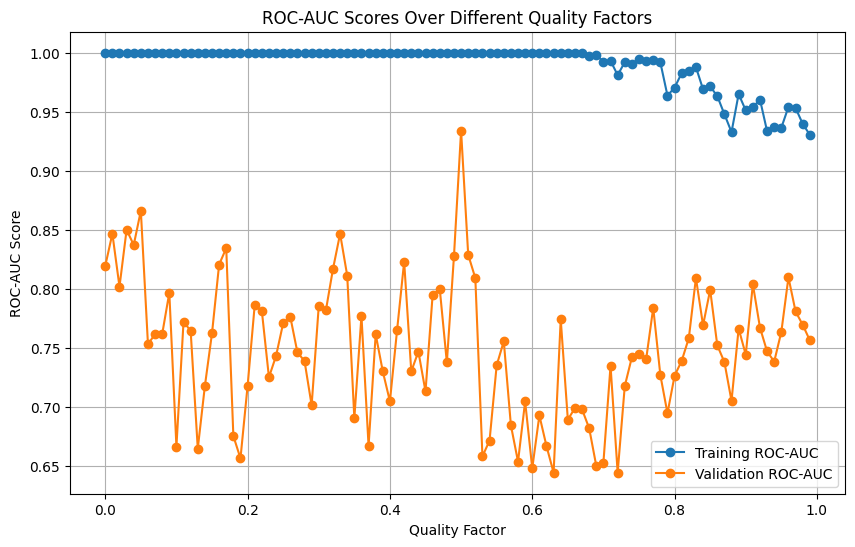

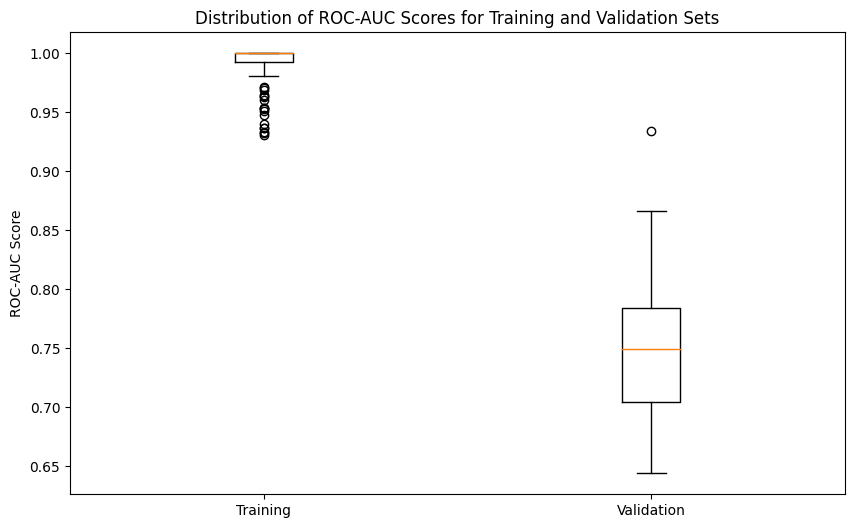

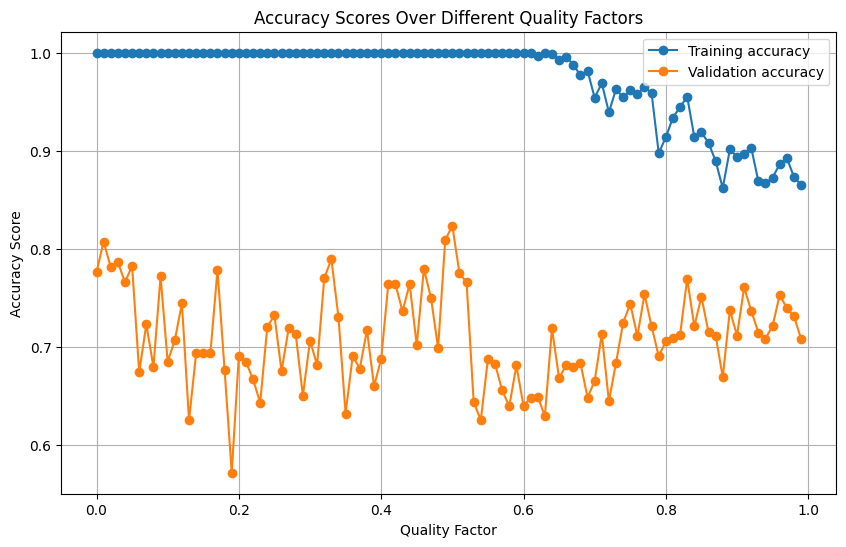

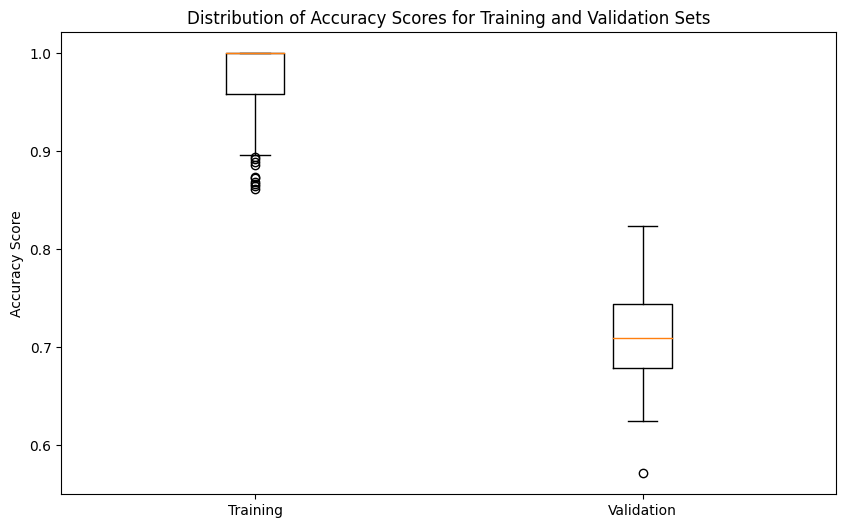

In [9]:
from problem import get_train_data
import numpy as np
import sys
import matplotlib.pyplot as plt

data_train = get_train_data()

all_results = []

# Redirect stdout to suppress print statements inside quality_selector
original_stdout = sys.stdout
sys.stdout = open('/dev/null', 'w')  # On Windows, use 'nul'; on Unix-like systems, use '/dev/null'

for i in range(100):
    quality_factor = i / 100.0  # quality factor ranges from 0 to 1
 
    data_train_selected = quality_selector(data_train, quality_factor)

    labels_train = data_train_selected['participants_asd']

    results = evaluation(data_train_selected.drop('participants_asd', axis=1), labels_train)

    all_results.append(results)


# Restore the original stdout
sys.stdout = original_stdout

# calculate the mean and standard deviation for each metric across all iterations
mean_roc_auc_train = np.mean([np.mean(result['train_roc_auc']) for result in all_results])
std_roc_auc_train = np.mean([np.std(result['train_roc_auc']) for result in all_results])

mean_accuracy_train = np.mean([np.mean(result['train_accuracy']) for result in all_results])
std_accuracy_train = np.mean([np.std(result['train_accuracy']) for result in all_results])

print("Overall Training score ROC-AUC: {:.3f} +- {:.3f}".format(mean_roc_auc_train, std_roc_auc_train))
print("Overall Training score accuracy: {:.3f} +- {:.3f}".format(mean_accuracy_train, std_accuracy_train ))

train_roc_auc_values = [np.mean(result['train_roc_auc']) for result in all_results]
val_roc_auc_values = [np.mean(result['test_roc_auc']) for result in all_results]

train_accuracy_values = [np.mean(result['train_accuracy']) for result in all_results]
val_accuracy_values = [np.mean(result['test_accuracy']) for result in all_results]


# Plotting the ROC-AUC values over different quality factors
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 1, 0.01), train_roc_auc_values, label='Training ROC-AUC', marker='o')
plt.plot(np.arange(0, 1, 0.01), val_roc_auc_values, label='Validation ROC-AUC', marker='o')

plt.title('ROC-AUC Scores Over Different Quality Factors')
plt.xlabel('Quality Factor')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot([train_roc_auc_values, val_roc_auc_values], labels=['Training', 'Validation'])
plt.title('Distribution of ROC-AUC Scores for Training and Validation Sets')
plt.ylabel('ROC-AUC Score')
plt.show()


# Plotting the accuracy values over different quality factors
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 1, 0.01), train_accuracy_values, label='Training accuracy', marker='o')
plt.plot(np.arange(0, 1, 0.01), val_accuracy_values, label='Validation accuracy', marker='o')

plt.title('Accuracy Scores Over Different Quality Factors')
plt.xlabel('Quality Factor')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot([train_accuracy_values, val_accuracy_values], labels=['Training', 'Validation'])
plt.title('Distribution of Accuracy Scores for Training and Validation Sets')
plt.ylabel('Accuracy Score')
plt.show()

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).